In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import skew
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error as mae,mean_squared_error as mse
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
import pickle

In [2]:
df=pd.read_csv("airbnb prices.csv")
df.head()

,room_id,survey_id,host_id,room_type,country,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,name,last_modified,latitude,longitude,location
0,10176931,1476,49180562,Shared room,NaN,Amsterdam,NaN,De Pijp / Rivierenbuurt,7,4.5,2,1.0,NaN,156.0,NaN,Red Light/ Canal view apartment (Shared),2017-07-23 13:06:27.391699,52.356209,4.887491,0101000020E610000033FAD170CA8C13403BC5AA41982D...
1,8935871,1476,46718394,Shared room,NaN,Amsterdam,NaN,Centrum West,45,4.5,4,1.0,NaN,126.0,NaN,Sunny and Cozy Living room in quite neighbours,2017-07-23 13:06:23.607187,52.378518,4.896120,0101000020E6100000842A357BA095134042791F477330...
2,14011697,1476,10346595,Shared room,NaN,Amsterdam,NaN,Watergraafsmeer,1,0.0,3,1.0,NaN,132.0,NaN,Amsterdam,2017-07-23 13:06:23.603546,52.338811,4.943592,0101000020E6100000A51133FB3CC613403543AA285E2B...
3,6137978,1476,8685430,Shared room,NaN,Amsterdam,NaN,Centrum West,7,5.0,4,1.0,NaN,121.0,NaN,Canal boat RIDE in Amsterdam,2017-07-23 13:06:22.689787,52.376319,4.890028,0101000020E6100000DF180280638F134085EE92382B30...
4,18630616,1476,70191803,Shared room,NaN,Amsterdam,NaN,De Baarsjes / Oud West,1,0.0,2,1.0,NaN,93.0,NaN,One room for rent in a three room appartment,2017-07-23 13:06:19.681469,52.370384,4.852873,0101000020E6100000CD902A8A57691340187B2FBE682F...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18723 entries, 0 to 18722
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   room_id               18723 non-null  int64  
 1   survey_id             18723 non-null  int64  
 2   host_id               18723 non-null  int64  
 3   room_type             18723 non-null  object 
 4   country               0 non-null      float64
 5   city                  18723 non-null  object 
 6   borough               0 non-null      float64
 7   neighborhood          18723 non-null  object 
 8   reviews               18723 non-null  int64  
 9   overall_satisfaction  18723 non-null  float64
 10  accommodates          18723 non-null  int64  
 11  bedrooms              18723 non-null  float64
 12  bathrooms             0 non-null      float64
 13  price                 18723 non-null  float64
 14  minstay               0 non-null      float64
 15  name               

#### Amsterdam located in Netherlands 

In [4]:
df.drop(["country","borough","bathrooms","minstay"],axis=1,inplace=True)       # drop columns which has 0 values

In [5]:
df.isna().sum()

room_id                  0
survey_id                0
host_id                  0
room_type                0
city                     0
neighborhood             0
reviews                  0
overall_satisfaction     0
accommodates             0
bedrooms                 0
price                    0
name                    52
last_modified            0
latitude                 0
longitude                0
location                 0
dtype: int64

In [6]:
df.drop("name",axis=1,inplace=True)                         # for predicting price, name of property not required so droped that

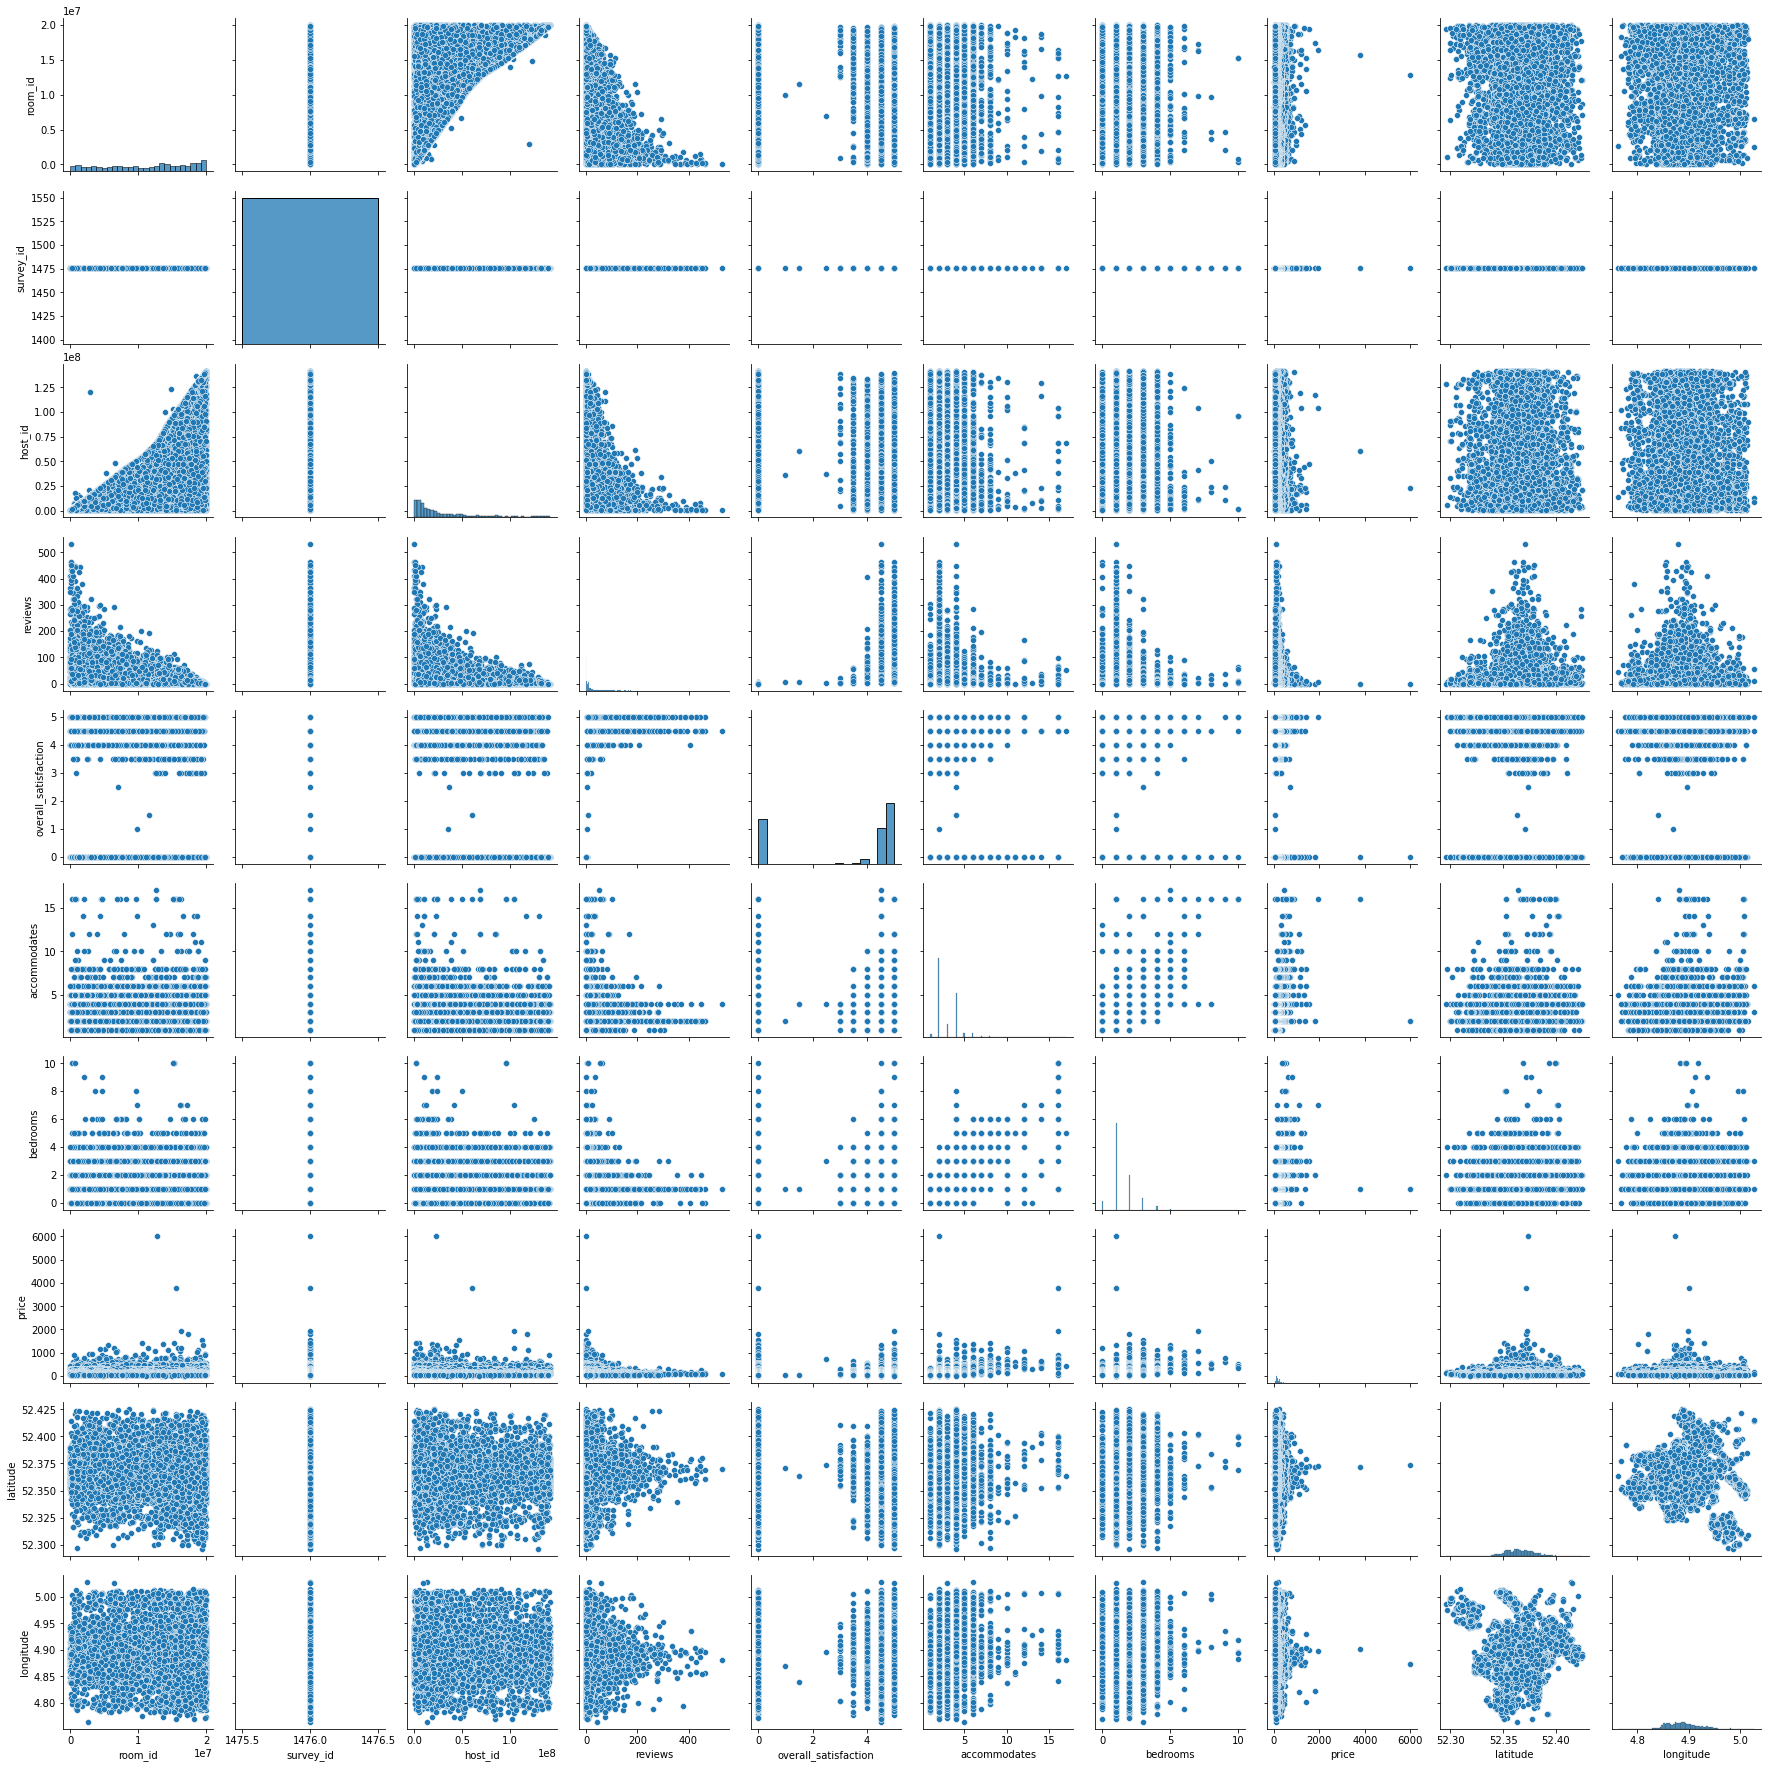

In [7]:
sns.pairplot(df)

<AxesSubplot:>

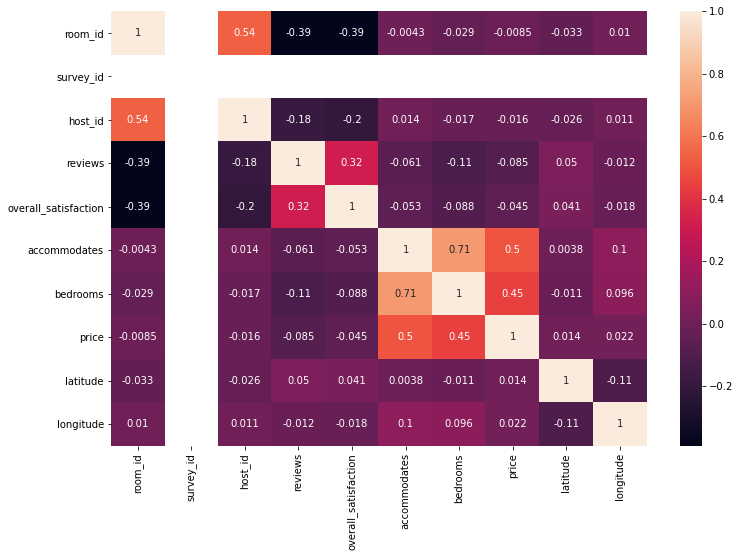

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)

#### What are types of  room available?

<AxesSubplot:xlabel='room_type', ylabel='count'>

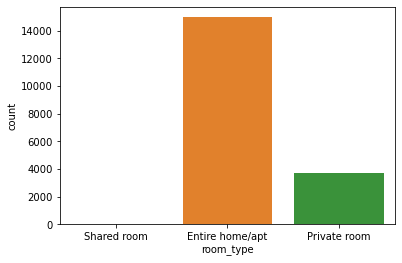

In [9]:
sns.countplot(df["room_type"])                     

In [10]:
df["room_type"].value_counts()

Entire home/apt    14978
Private room        3682
Shared room           63
Name: room_type, dtype: int64

#### Count neighborhood to get where properties situated most

<AxesSubplot:xlabel='count', ylabel='neighborhood'>

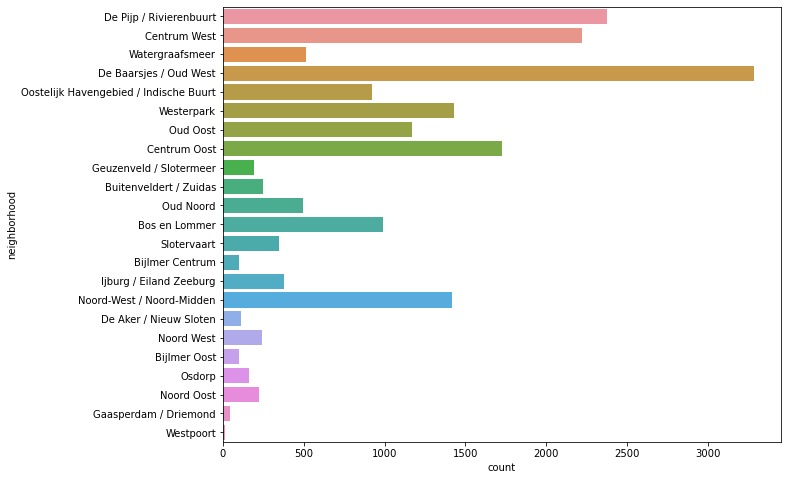

In [11]:
plt.figure(figsize=(10,8))
sns.countplot(y=df["neighborhood"])

#### How many property got 0 review

In [12]:
df["reviews"].value_counts()

0      2984
1      1510
2      1246
3      1103
4       925
       ... 
202       1
211       1
323       1
180       1
463       1
Name: reviews, Length: 284, dtype: int64

#### What is the overall_statisfaction count by rating

<AxesSubplot:xlabel='overall_satisfaction', ylabel='count'>

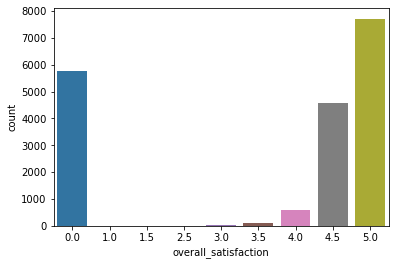

In [13]:
sns.countplot(df["overall_satisfaction"])

In [14]:
df["overall_satisfaction"].value_counts()

5.0    7708
0.0    5748
4.5    4559
4.0     577
3.5     109
3.0      19
2.5       1
1.5       1
1.0       1
Name: overall_satisfaction, dtype: int64

#### Count the property with no of bedrooms

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

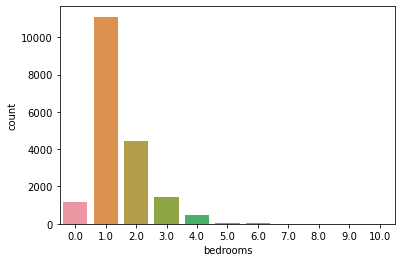

In [15]:
sns.countplot(df["bedrooms"])

In [16]:
df.bedrooms.value_counts()

1.0     11101
2.0      4456
3.0      1444
0.0      1154
4.0       473
5.0        62
6.0        19
10.0        5
7.0         4
8.0         3
9.0         2
Name: bedrooms, dtype: int64

In [17]:
df.groupby("bedrooms").overall_satisfaction.sum()

bedrooms
0.0      3828.5
1.0     38350.0
2.0     14165.5
3.0      3880.0
4.0      1251.0
5.0       223.5
6.0        65.5
7.0         9.5
8.0         9.0
9.0         5.0
10.0       19.5
Name: overall_satisfaction, dtype: float64

#### Which properties has no bedroom

In [18]:
df[df.bedrooms==0.0]["room_type"].value_counts()

Entire home/apt    852
Private room       302
Name: room_type, dtype: int64

In [19]:
df.drop(df.index[(df["bedrooms"]==0.0)&(df["room_type"]=="Entire home/apt")],inplace=True)

In [20]:
df.drop(df.index[(df["bedrooms"]==0.0)&(df["room_type"]=="Private room")],inplace=True)

In [21]:
df[df.bedrooms==0.0]["room_type"].value_counts()

Series([], Name: room_type, dtype: int64)

#### Count of accomodates to check where is most availability

In [22]:
df["accommodates"].value_counts()

2     9133
4     5453
3     1491
6      472
5      465
1      337
8      105
7       52
16      20
10      15
12       9
9        8
14       6
11       2
17       1
Name: accommodates, dtype: int64

#### Check on which price most of the properties are available.

In [23]:
df.groupby('room_type').price.mean()

room_type
Entire home/apt    184.361886
Private room       105.509172
Shared room        103.682540
Name: price, dtype: float64

#### How many frequently get reviews

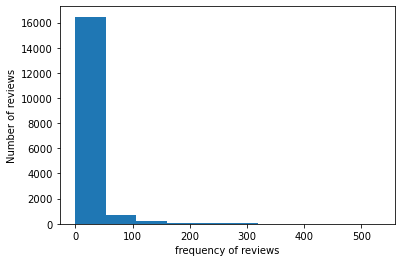

In [24]:
plt.hist(df["reviews"])
plt.xlabel('frequency of reviews')
plt.ylabel('Number of reviews')
plt.show()

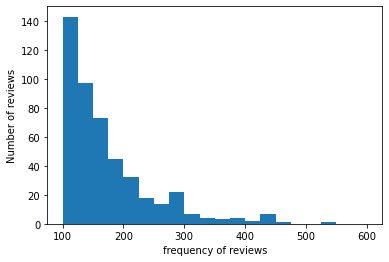

In [25]:
plt.hist(df.reviews,bins=20,range=(100, 600))
plt.xlabel('frequency of reviews')
plt.ylabel('Number of reviews')
plt.show()

#### Check satisfication of guest about property

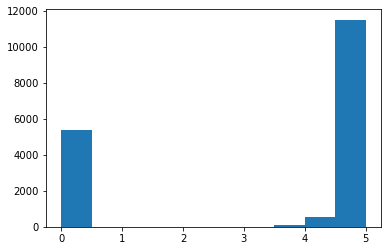

In [26]:
plt.hist(df["overall_satisfaction"])
plt.show()

#### Is there any relationship between reviews and price

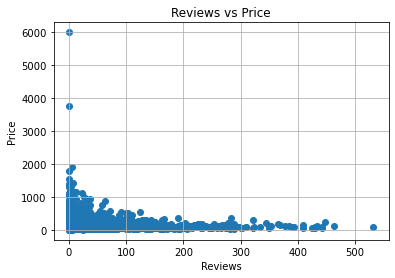

In [27]:
plt.scatter(x=df["reviews"],y=df["price"])
plt.xlabel("Reviews")
plt.ylabel("Price")
plt.title("Reviews vs Price")
plt.grid(True)
plt.show()

#### Outliers

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

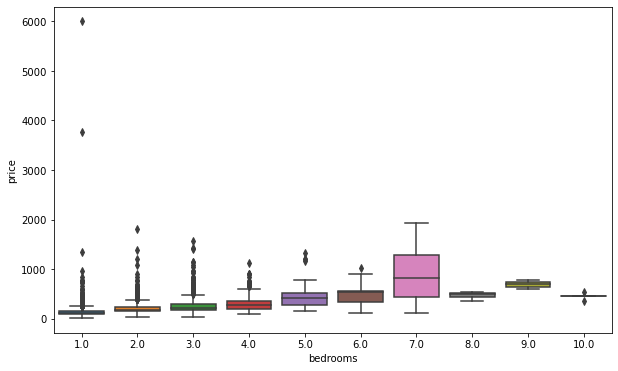

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(df["bedrooms"],df["price"])

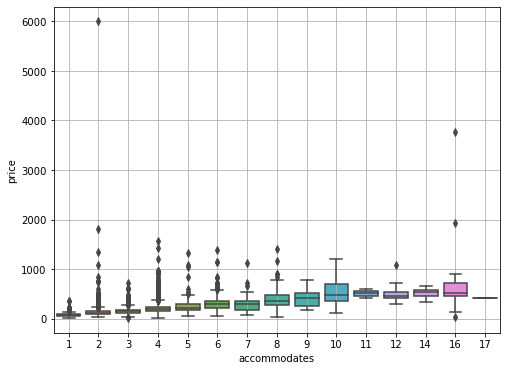

In [29]:
plt.figure(figsize=(8,6))
sns.boxplot(df["accommodates"],df["price"])
plt.grid(True)

In [30]:
df[(df["price"]>1500)]

,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,last_modified,latitude,longitude,location
178,12837950,1476,22855069,Entire home/apt,Amsterdam,Westerpark,0,0.0,2,1.0,6000.0,2017-07-23 06:22:10.340921,52.373990,4.873597,0101000020E6100000EC884336907E1340F98381E7DE2F...
179,17377934,1476,117439187,Entire home/apt,Amsterdam,Geuzenveld / Slotermeer,0,0.0,2,2.0,1799.0,2017-07-23 06:22:10.339020,52.371958,4.821506,0101000020E610000001DF6DDE3849134027BEDA519C2F...
180,15626614,1476,60409350,Entire home/apt,Amsterdam,Centrum Oost,0,0.0,16,1.0,3770.0,2017-07-23 06:22:10.336066,52.371641,4.901265,0101000020E6100000261E5036E59A1340266DAAEE912F...
181,16344025,1476,104389329,Entire home/apt,Amsterdam,Centrum West,6,5.0,16,7.0,1920.0,2017-07-23 06:22:10.333495,52.372837,4.898500,0101000020E6100000F2D24D62109813408FDE701FB92F...
182,19408111,1476,47078997,Entire home/apt,Amsterdam,Centrum West,0,0.0,4,3.0,1558.0,2017-07-23 06:22:10.330886,52.372894,4.899198,0101000020E6100000B2834A5CC7981340F46F97FDBA2F...


In [31]:
df.drop([178,179,180,182],axis=0,inplace=True)

-0.7906961901607579


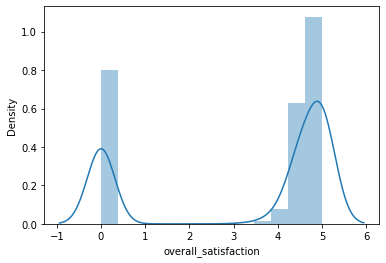

In [32]:
print(skew(df["overall_satisfaction"]))
sns.distplot(df["overall_satisfaction"])
plt.show()

3.428240459000659


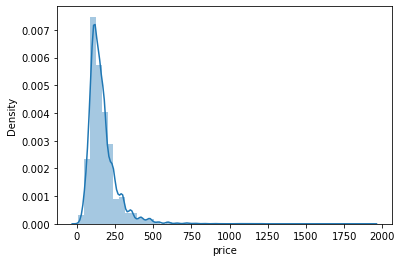

In [33]:
print(skew(df["price"]))
sns.distplot(df["price"])
plt.show()

In [34]:
df["price"]=np.sqrt(df["price"])

In [35]:
df.head()

,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,last_modified,latitude,longitude,location
0,10176931,1476,49180562,Shared room,Amsterdam,De Pijp / Rivierenbuurt,7,4.5,2,1.0,12.489996,2017-07-23 13:06:27.391699,52.356209,4.887491,0101000020E610000033FAD170CA8C13403BC5AA41982D...
1,8935871,1476,46718394,Shared room,Amsterdam,Centrum West,45,4.5,4,1.0,11.224972,2017-07-23 13:06:23.607187,52.378518,4.896120,0101000020E6100000842A357BA095134042791F477330...
2,14011697,1476,10346595,Shared room,Amsterdam,Watergraafsmeer,1,0.0,3,1.0,11.489125,2017-07-23 13:06:23.603546,52.338811,4.943592,0101000020E6100000A51133FB3CC613403543AA285E2B...
3,6137978,1476,8685430,Shared room,Amsterdam,Centrum West,7,5.0,4,1.0,11.000000,2017-07-23 13:06:22.689787,52.376319,4.890028,0101000020E6100000DF180280638F134085EE92382B30...
4,18630616,1476,70191803,Shared room,Amsterdam,De Baarsjes / Oud West,1,0.0,2,1.0,9.643651,2017-07-23 13:06:19.681469,52.370384,4.852873,0101000020E6100000CD902A8A57691340187B2FBE682F...


In [36]:
x=df.loc[:,["room_type","neighborhood","overall_satisfaction","accommodates","bedrooms","latitude","longitude"]]
y=df.loc[:,"price"]

In [37]:
x

,room_type,neighborhood,overall_satisfaction,accommodates,bedrooms,latitude,longitude
0,Shared room,De Pijp / Rivierenbuurt,4.5,2,1.0,52.356209,4.887491
1,Shared room,Centrum West,4.5,4,1.0,52.378518,4.896120
2,Shared room,Watergraafsmeer,0.0,3,1.0,52.338811,4.943592
3,Shared room,Centrum West,5.0,4,1.0,52.376319,4.890028
4,Shared room,De Baarsjes / Oud West,0.0,2,1.0,52.370384,4.852873
...,...,...,...,...,...,...,...
18718,Private room,Bijlmer Centrum,5.0,3,1.0,52.319794,4.955638
18719,Private room,Bijlmer Centrum,5.0,4,1.0,52.319080,4.954822
18720,Private room,Geuzenveld / Slotermeer,0.0,1,1.0,52.384028,4.838403
18721,Private room,Centrum West,4.5,2,1.0,52.372120,4.890982


In [38]:
y

0        12.489996
1        11.224972
2        11.489125
3        11.000000
4         9.643651
           ...    
18718     5.656854
18719     4.898979
18720     6.164414
18721     6.000000
18722     5.916080
Name: price, Length: 17565, dtype: float64

In [39]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.33,random_state=1)

In [40]:
room=["Shared room","Private room","Entire home/apt"]

In [41]:
df["neighborhood"].unique()

array(['De Pijp / Rivierenbuurt', 'Centrum West', 'Watergraafsmeer',
       'De Baarsjes / Oud West', 'Oostelijk Havengebied / Indische Buurt',
       'Westerpark', 'Oud Oost', 'Centrum Oost',
       'Geuzenveld / Slotermeer', 'Buitenveldert / Zuidas', 'Oud Noord',
       'Bos en Lommer', 'Slotervaart', 'Bijlmer Centrum',
       'Ijburg / Eiland Zeeburg', 'Noord-West / Noord-Midden',
       'De Aker / Nieuw Sloten', 'Noord West', 'Bijlmer Oost', 'Osdorp',
       'Noord Oost', 'Gaasperdam / Driemond', 'Westpoort'], dtype=object)

In [42]:
df["neighborhood"].value_counts(ascending=True)

Westpoort                                   10
Gaasperdam / Driemond                       42
Bijlmer Centrum                             85
Bijlmer Oost                                91
De Aker / Nieuw Sloten                     104
Osdorp                                     156
Geuzenveld / Slotermeer                    182
Noord Oost                                 214
Noord West                                 233
Buitenveldert / Zuidas                     241
Slotervaart                                331
Ijburg / Eiland Zeeburg                    357
Watergraafsmeer                            432
Oud Noord                                  458
Oostelijk Havengebied / Indische Buurt     875
Bos en Lommer                              926
Oud Oost                                  1126
Westerpark                                1355
Noord-West / Noord-Midden                 1385
Centrum Oost                              1592
Centrum West                              1975
De Pijp / Riv

In [43]:
neighbor=["Westpoort","Gaasperdam / Driemond","Bijlmer Oost","Bijlmer Centrum","De Aker / Nieuw Sloten","Osdorp","Geuzenveld / Slotermeer","Noord Oost","Noord West","Buitenveldert / Zuidas","Slotervaart","Ijburg / Eiland Zeeburg","Oud Noord","Watergraafsmeer","Oostelijk Havengebied / Indische Buurt","Bos en Lommer","Oud Oost","Noord-West / Noord-Midden","Westerpark","Centrum Oost","Centrum West","De Pijp / Rivierenbuurt","De Baarsjes / Oud West"]

In [44]:
df.head()

,room_id,survey_id,host_id,room_type,city,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,last_modified,latitude,longitude,location
0,10176931,1476,49180562,Shared room,Amsterdam,De Pijp / Rivierenbuurt,7,4.5,2,1.0,12.489996,2017-07-23 13:06:27.391699,52.356209,4.887491,0101000020E610000033FAD170CA8C13403BC5AA41982D...
1,8935871,1476,46718394,Shared room,Amsterdam,Centrum West,45,4.5,4,1.0,11.224972,2017-07-23 13:06:23.607187,52.378518,4.896120,0101000020E6100000842A357BA095134042791F477330...
2,14011697,1476,10346595,Shared room,Amsterdam,Watergraafsmeer,1,0.0,3,1.0,11.489125,2017-07-23 13:06:23.603546,52.338811,4.943592,0101000020E6100000A51133FB3CC613403543AA285E2B...
3,6137978,1476,8685430,Shared room,Amsterdam,Centrum West,7,5.0,4,1.0,11.000000,2017-07-23 13:06:22.689787,52.376319,4.890028,0101000020E6100000DF180280638F134085EE92382B30...
4,18630616,1476,70191803,Shared room,Amsterdam,De Baarsjes / Oud West,1,0.0,2,1.0,9.643651,2017-07-23 13:06:19.681469,52.370384,4.852873,0101000020E6100000CD902A8A57691340187B2FBE682F...


In [45]:
ct=ColumnTransformer(transformers=[("encoder",OrdinalEncoder(categories=[room,neighbor]),["room_type","neighborhood"])],remainder="passthrough")

In [46]:
gb=GradientBoostingRegressor()

In [47]:
pipe=make_pipeline(ct,gb)
pipe.fit(xtrain,ytrain)
ypred=pipe.predict(xtest)
print(f"R2_score :- {r2_score(ytest,ypred)}")
print(f"MAE :- {mae(ytest,ypred)}")
print(f"MSE :- {mse(ytest,ypred)}")
print(f"RMSE :- {np.sqrt(mse(ytest,ypred))}")

R2_score :- 0.5340012483473833
MAE :- 1.527297673062654
MSE :- 4.547436138446458
RMSE :- 2.1324718376678407


In [48]:
pipe.score(xtrain,ytrain)

0.5693190427003298

In [49]:
xgb=XGBRegressor()

In [50]:
pipe1=make_pipeline(ct,xgb)
pipe1.fit(xtrain,ytrain)
ypred=pipe1.predict(xtest)
print(f"R2_score :- {r2_score(ytest,ypred)}")
print(f"MAE :- {mae(ytest,ypred)}")
print(f"MSE :- {mse(ytest,ypred)}")
print(f"RMSE :- {np.sqrt(mse(ytest,ypred))}")

R2_score :- 0.5073599624494862
MAE :- 1.5832359399991542
MSE :- 4.807414401987158
RMSE :- 2.1925816751006466


In [51]:
para={"n_estimators":[10,50,100,500],"learning_rate":[1,0.1,0.001],"subsample":[1,2]}

In [52]:
grid=GridSearchCV(GradientBoostingRegressor(),para,refit=True,verbose=2)
pipe2=make_pipeline(ct,grid)
pipe2.fit(xtrain,ytrain)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ......learning_rate=1, n_estimators=10, subsample=1; total time=   0.1s
[CV] END ......learning_rate=1, n_estimators=10, subsample=1; total time=   0.1s
[CV] END ......learning_rate=1, n_estimators=10, subsample=1; total time=   0.1s
[CV] END ......learning_rate=1, n_estimators=10, subsample=1; total time=   0.1s
[CV] END ......learning_rate=1, n_estimators=10, subsample=1; total time=   0.1s
[CV] END ......learning_rate=1, n_estimators=10, subsample=2; total time=   0.0s
[CV] END ......learning_rate=1, n_estimators=10, subsample=2; total time=   0.0s
[CV] END ......learning_rate=1, n_estimators=10, subsample=2; total time=   0.0s
[CV] END ......learning_rate=1, n_estimators=10, subsample=2; total time=   0.0s
[CV] END ......learning_rate=1, n_estimators=10, subsample=2; total time=   0.0s
[CV] END ......learning_rate=1, n_estimators=50, subsample=1; total time=   0.8s
[CV] END ......learning_rate=1, n_estimators=50

[CV] END .learning_rate=0.001, n_estimators=100, subsample=1; total time=   1.8s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=1; total time=   1.8s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=1; total time=   2.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=1; total time=   2.3s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=2; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=2; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=2; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=2; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=100, subsample=2; total time=   0.0s
[CV] END .learning_rate=0.001, n_estimators=500, subsample=1; total time=   9.2s
[CV] END .learning_rate=0.001, n_estimators=500, subsample=1; total time=   9.3s
[CV] END .learning_rate=0.001, n_estimators=500, subsample=1; total time=   9.3s
[CV] END .learning_rate=0.00

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OrdinalEncoder(categories=[['Shared '
                                                                              'room',
                                                                              'Private '
                                                                              'room',
                                                                              'Entire '
                                                                              'home/apt'],
                                                                             ['Westpoort',
                                                                              'Gaasperdam '
                                                                              '/ '
                                               

In [53]:
grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1}

In [55]:
gboost=GradientBoostingRegressor(subsample=1,n_estimators=100)

In [56]:
pipe3=make_pipeline(ct,gboost)
pipe3.fit(xtrain,ytrain)
ypred=pipe3.predict(xtest)
print(f"R2_score :- {r2_score(ytest,ypred)}")
print(f"MAE :- {mae(ytest,ypred)}")
print(f"MSE :- {mse(ytest,ypred)}")
print(f"RMSE :- {np.sqrt(mse(ytest,ypred))}")

R2_score :- 0.5340528580802066
MAE :- 1.5269605018193197
MSE :- 4.546932506272972
RMSE :- 2.1323537479210555


In [57]:
pickle.dump(pipe,open('airbnb.pkl','wb'))